# TP1 : Images radio, protéines et homologie persistante

## Préambule

### Modules requis

In [ ]:
!pip install numpy scikit-learn torch torchvision gudhi cripser biopython torchmetrics tqdm pydicom

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
import torchmetrics
import gudhi
import gudhi.representations
import cripser
import pydicom as dicom
import Bio.PDB as pdb
from scipy.ndimage import zoom
import zipfile
import urllib

from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Images de chiffres

### Dataset
On utilisera en préambule le jeu de données MNIST qui contient des images de chiffres en noir et blanc.

Chaque image est encodée par un tableau de taille `(1,28,28)`, où la première coordonnée correspond au nombre de canaux de l'image (ici un seul, pour une image en couleur ce serait 3 canaux pour chaque couleur primaire Rouge, Vert, Bleu). Les images sont encodées en niveaux de gris avec un nombre flottant entre 0 et 1 pour chaque pixel.

Le module `datasets` de la libraire `torchvision` permet de récupérer ce jeu de données au format `Tensor` de pyTorch.

In [3]:
X_train = datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor())
dataloader_train = torch.utils.data.DataLoader(X_train, batch_size=60, shuffle=True)

L'objet `X_train` est ici un itérateur qui renvoie, à chaque itération, l'image et sa classification (le chiffre représenté dans l'image). Le dataloader permet de mélanger aléatoirement le dataset et pourra être utilisé comme un itérateur au moment d'entraîner un modèle d'apprentissage afin de découper le jeu de données en plusieurs parts plus petites ("batches") pour diminuer la place requise en mémoire vive.

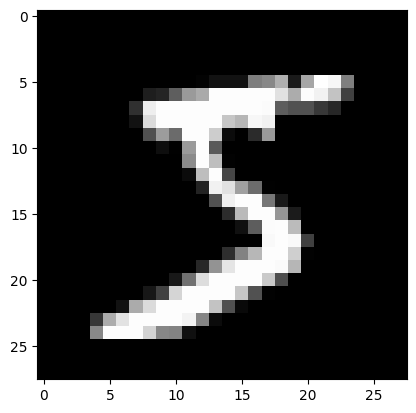

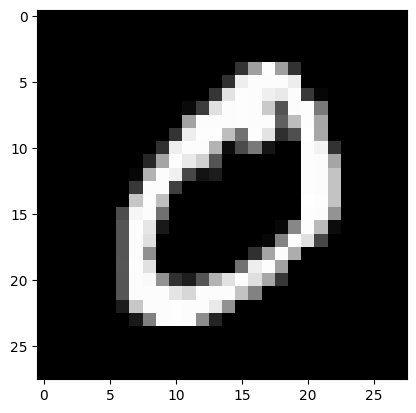

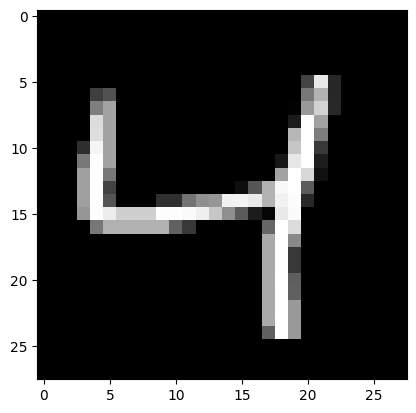

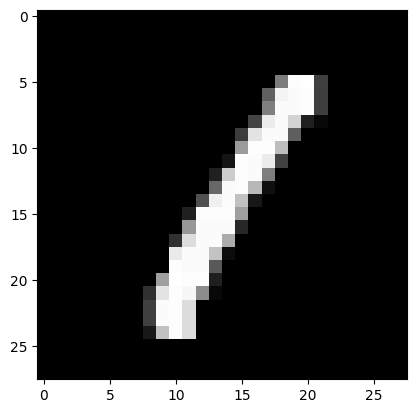

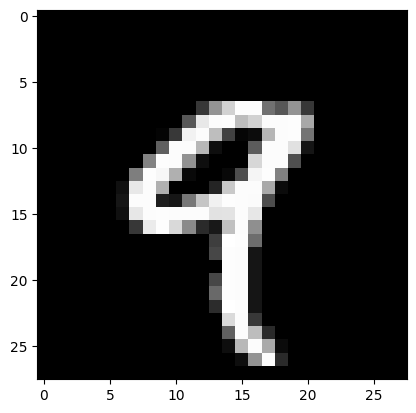

In [4]:
for i in range(5):
    plt.imshow(X_train[i][0][0], cmap="gray")
    plt.show()

Rajoutez ci-dessous les définitions du dataset de test (`X_test` et `dataloader_test`) sur le modèle du jeu d'entraînement:

In [5]:
X_test           = None
dataloader_test  = None

### Réseau de neurones convolutionnel

Notre objectif est de construire un réseau de neurone simple capable de reconnaître un chiffre dans une image.

#### Formulation du réseau de neurones
Le réseau de neurones ci-dessous est le réseau le plus simple possible que l'on puisse définir sur nos entrées.
Il ne comprend qu'une seule couche linéaire, c'est à dire que le réseau va devoir ajuster des poids indépendamment pour chaque pixel de l'image lors de l'entraînement.

In [6]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.fc1   = nn.Linear(in_channels*28*28, num_classes)

    def forward(self, x):
        x = self.fc1(x.reshape(x.shape[0], -1))
        return x

In [7]:
model = Net(in_channels=1, num_classes=10).to(device)

Le modèle doit ajuster (28×28 + 1)×10 = 7850 poids lors de l'entraînement.

In [8]:
num_weights = 0
for name, values in model.named_parameters():
    print("Paramètres", name, ":", np.prod(values.shape), "poids")
    num_weights += np.prod(values.shape)
print("Nombre total de paramètres:", num_weights)

Paramètres fc1.weight : 7840 poids
Paramètres fc1.bias : 10 poids
Nombre total de paramètres: 7850


**Exercice**: Remplacez l'architecture du réseau de neurone défini ci-dessus par une architecture de réseau de neurone convolutionnel constituée des couches successives suivantes:
* Une couche convolutionnelle `Conv2d` avec un noyau 3 par 3, un remplissage (padding) de 1, et 8 canaux en sortie.
* Une autre couche convolutionnelle avec les même paramètres et 4 canaux en sortie
* Une couche linéaire finale qui produit un vecteur de 10 valeurs.

Chaque application d'une couche convolutionnelle sera suivie d'une activation (`F.relu`) et d'un pooling (`MaxPool2d`) avec un noyau 2 par 2 et un pas (stride) de 2.

Pour la couche linéaire, il est nécessaire de connaître la taille du vecteur en entrée. Celui-ci doit être de la forme `(4,7,7)` (chaque pooling divise la taille de l'image par 2).

#### Entraînement
Pour l'entraînement, on utilise la fonction de pénalisation `CrossEntropyLoss`, et l'optimiseur `Adam`.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Complétez la section suivante afin d'entraîner le réseau de neurones. Pour chaque batch, il s'agit de faire une prédiction avec le modèle, puis de calculer une `loss` avec `criterion` pour comparer la prédiction à la réalité, puis d'utiliser `loss.backward()` pour calculer les gradients, et `optimizer.step()` pour mettre à jour les paramètres du réseau.

In [ ]:
num_epochs = 10
ls = []
for epoch in range(num_epochs):
    model.train() # Indique au modèle que ses paramètres peuvent être modifiés
    print(f"Epoch {epoch + 1} / {num_epochs}:")
    for xs, ys in tqdm(dataloader_train, ncols=80):
        optimizer.zero_grad() # Remet les gradients à zéro à chaque itération. Le comportement par défaut est de les accumuler
        loss = 0 # À modifier!
    print("  Current loss:", loss)

#### Test
La case suivante calcule le pourcentage de prédictions réussies par le réseau:

In [11]:
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
model.eval()
with torch.no_grad():
    for xs, ys in dataloader_test:
        zs = model(xs.to(device))
        _, preds = torch.max(zs, 1)
        acc(preds, ys.to(device))
test_accuracy = acc.compute()
print("Test accuracy:", test_accuracy.item())

Test accuracy: 0.10270000249147415


Pour illustrer, affichez, pour les 5 premières images du dataset, l'image elle même et la classification prédite par le réseau de neurones.

In [12]:
pass

### Homologie persistante cubique

#### Calcul des codes-barres
Pour les images, le calcul de l'homologie persistante cubique est effectué à l'aide du module `cripser`.
La fonction `computePH` prend en entrée un tableau numpy (sur 2 ou 3 axes), et retourne un tableau de taille `(N,9)`.
Chaque ligne du tableau correspond à une caractéristique topologique. Les 9 valeurs sont, dans l'ordre:
* Le degré homologique (0 pour les composantes connexes, 1 pour les cycles, 2 pour les cavités)
* Le temps d'arrivée de la caractéristique dans la filtration
* L'instant où meurt la caractéristique
* Les 3 coordonnées du pixel qui provoque la naissance de la caractéristique
* Les 3 coordonnées du pixel qui provoque la mort de la caractéristique

**NB**: Pour les images en 2 dimensions, la 3ème coordonnées des deux pixels sont mises à 0.

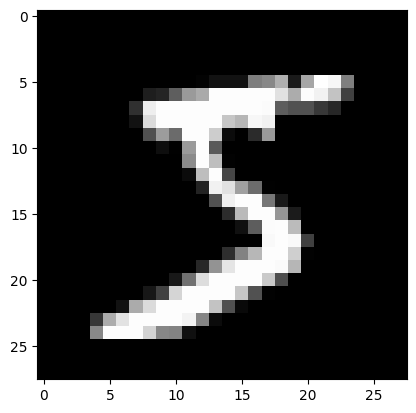

Deg. 0 : [ 0.0 , 1.7976931348623157e+308 ]
Deg. 1 : [ 0.9411764740943909 , 0.9921568632125854 ]
Deg. 1 : [ 0.6745098233222961 , 0.9921568632125854 ]
Deg. 1 : [ 0.0 , 1.0 ]


In [13]:
img = X_train[0][0]
plt.imshow(img[0], cmap="gray")
plt.show()
bcd = cripser.computePH(img)
for bar in bcd:
    print("Deg.", int(bar[0]), ": [", bar[1], ",", bar[2], "]")

Ici, le grand cycle d'intervalle `[0,1]` correspond à la zone en noir autour du 5, qui ne se referme qu'à la toute fin de la filtration. Pour capturer les éventuels cycles provenant des pixels blancs, par exemple la boucle formée par un '6' ou un '9', il faut inverser le sens de filtration. La solution la plus simple est de passer l'image en négatif:

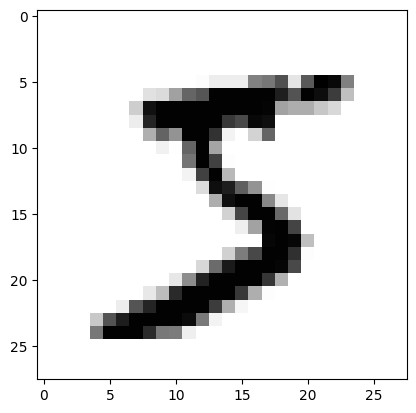

Deg. 0 : [ 0.00784313678741455 , 0.011764705181121826 ]
Deg. 0 : [ 0.00784313678741455 , 0.05098038911819458 ]
Deg. 0 : [ 0.00784313678741455 , 0.11764705181121826 ]
Deg. 0 : [ 0.00784313678741455 , 0.2549019455909729 ]
Deg. 0 : [ 0.00784313678741455 , 0.32549017667770386 ]
Deg. 0 : [ 0.0 , 1.7976931348623157e+308 ]


In [14]:
img = 1-X_train[0][0]
plt.imshow(img[0], cmap="gray")
plt.show()
bcd_rev = cripser.computePH(img)
for bar in bcd_rev:
    print("Deg.", int(bar[0]), ": [", bar[1], ",", bar[2], "]")

Dans cet exemple, l'homologie persistante ne détecte aucun cycle, mais détecte plusieurs composantes connexes qui se se rejoignent en une seule à la fin de la filtration.

Les fonctions ci-dessous permettent de convertir un code-barre calculé par `cripser` au format utilisé par `gudhi`, une autre bibliothèque qui offre beaucoup plus de fonctionnalités mais est principalement concentrée sur les calculs sur des nuages de points. GUDHI permet, entre autres, de représenter graphiquement les codes-barres:

In [15]:
def to_gudhi(bcd):
    bars = []
    for k in range(3): # On inclut aussi le degré homologique 2 même s'il n'y a aucune cavité dans une image 2D
        mask = bcd[:,0] == k
        ints = bcd[mask][:,1:3]
        ints[ints > 1e300] = np.inf
        bars.append(ints)
    return bars

# Les représentations graphiques ne fonctionnent pas avec les codes-barres vides
def remove_empty_bcd(bars):
    return [ints for ints in bars if ints.size > 0]

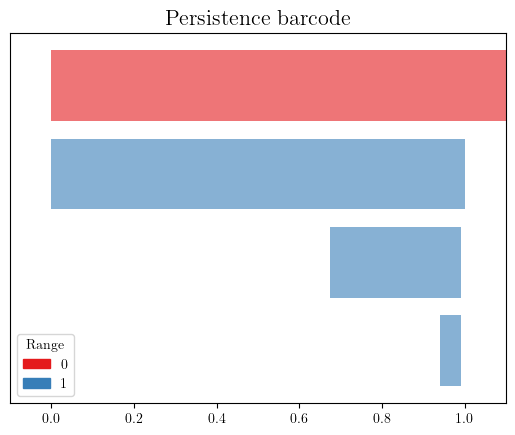

[array([[ 0., inf]]), array([[0.94117647, 0.99215686],
       [0.67450982, 0.99215686],
       [0.        , 1.        ]]), array([], shape=(0, 2), dtype=float64)]


In [16]:
bcd_gudhi     = to_gudhi(bcd)
bcd_gudhi_rev = to_gudhi(bcd_rev)
gudhi.plot_persistence_barcode(remove_empty_bcd(bcd_gudhi))
plt.show()
print(bcd_gudhi)

Le format de GUDHI est donné par une liste de tableaux d'intervalles, avec un tableau par degré homologique, dans l'ordre croissant.

On remarque ici que l'un de ces intervalles se termine seulement en +∞. Afin d'éviter les valeurs aberrantes, il est souvent désirable de couper le code-barre après un certain seuil (ici, un seuil de 1 semble approprié).

In [17]:
bcd_gudhi_     = list(map(lambda ints: np.minimum(ints, 1.), bcd_gudhi))
bcd_gudhi_rev_ = list(map(lambda ints: np.minimum(ints, 1.), bcd_gudhi_rev))
print(bcd_gudhi_)

[array([[0., 1.]]), array([[0.94117647, 0.99215686],
       [0.67450982, 0.99215686],
       [0.        , 1.        ]]), array([], shape=(0, 2), dtype=float64)]


**Exercice**: Pour chaque image du dataset MNIST, calculez les deux codes-barres (de l'image originale et de son négatif), en prenant soin de couper les valeurs pour rester entre 0 et 1.
Convertissez chaque code-barre au format GUDHI, et concaténez les deux listes obtenues en une seule liste de tableaux numpy pour chaque image.
Séparez ces codes-barres entre deux listes `X_train_bcd` et `X_test_bcd`.

In [18]:
# Exemple avec seulement le premier code-barre
X_train_bcd = [bcd_gudhi_ + bcd_gudhi_rev_]

#### Vectorisation
Comme le nombre de caractéristiques topologiques présentes dans une image peut varier énormément, les codes-barres ne permettent pas de définir directement une vectorisation qui aurait une dimension fixe. Pour obtenir de telles vectorisations, il existe plusieurs méthodes qui contiennent chacune seulement une partie de l'information traduite par les codes-barres. Parmi celles-ci, on trouve par exemple les courbes de Betti et les paysages de persistance.

La cellule ci-dessous calcule les courbes de Betti des codes-barres calculés précédemment. Le vecteur obtenu est un tableau numpy de dimension `(N, R)`, où N est le nombre de codes-barres donnés en entrée, et R est la résolution choisie. La vectorisation est obtenue en échantillonant la courbe de Betti de chaque code-barre sur l'intervalle donné par le paramètre `sample_range`.

Remplacez les courbes de Betti par une vectorisation via des [paysages de persistance](https://gudhi.inria.fr/python/latest/representations.html#landscapes) (même résolution, 2 paysages par code-barre).

In [20]:
BC = gudhi.representations.BettiCurve(sample_range=[0.,1.], resolution=100)

Y_train = [x[1] for x in X_train]
Y_test  = [x[1] for x in X_test]

X_train_ph = list(map(BC.fit_transform, X_train_bcd))
X_test_ph  = list(map(BC.fit_transform, X_test_bcd))

print("Dimensions d'un vecteur:", X_train_ph[0].shape)

X_train_ph = list(zip(X_train_ph, Y_train))
X_test_ph  = list(zip(X_test_ph,  Y_test))

Dimensions d'un vecteur: (6, 100)


In [21]:
dataloader_train_ph = torch.utils.data.DataLoader(X_train_ph, batch_size=60, shuffle=True)
dataloader_test_ph  = torch.utils.data.DataLoader(X_test_ph,  batch_size=60, shuffle=True)

#### Classification

Le réseau ci-dessous a été écrit pour les vecteurs obtenus via les courbes de Betti. Adaptez le aux paysages de persistance, et ajoutez une première couche convolutionnelle `Conv1d` (par exemple avec un noyau 11 par 11 et un padding de 5), suivie d'une activation ReLU et d'un pooling `MaxPool1d` (par exemple de noyau 5 par 5 avec un stride de 5).

In [22]:
class PHNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.fc    = nn.Linear(in_channels*100, num_classes)

    def forward(self, x):
        x = self.fc(x.reshape(x.shape[0], -1))
        return x

In [23]:
model = PHNet(in_channels=6, num_classes=10).to(device)

In [24]:
num_weights = 0
for name, values in model.named_parameters():
    print("Paramètres", name, ":", np.prod(values.shape), "poids")
    num_weights += np.prod(values.shape)
print("Nombre total de paramètres:", num_weights)

Paramètres fc.weight : 6000 poids
Paramètres fc.bias : 10 poids
Nombre total de paramètres: 6010


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
ls = []
for epoch in range(num_epochs):
    model.train() # Indique au modèle que ses paramètres peuvent être modifiés
    print(f"Epoch {epoch + 1} / {num_epochs}:")
    for i, (xs, ys) in enumerate(tqdm(dataloader_train_ph, ncols=80)):
        optimizer.zero_grad() # Remet les gradients à zéro à chaque itération. Le comportement par défaut est de les accumuler
        loss = 0 # À modifier!
    print("  Current loss:", loss)

In [27]:
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
model.eval()
with torch.no_grad():
    for xs, ys in dataloader_test_ph:
        zs = model(xs.float().to(device))
        _, preds = torch.max(zs, 1)
        acc(preds, ys.to(device))
test_accuracy = acc.compute()
print("Test accuracy:", test_accuracy.item())

Test accuracy: 0.3736000061035156


### Comparaison des deux méthodes

#### Invariance par transformations rigides
L'homologie persistante prise telle quelle n'est en fait pas très adaptée pour les problèmes de reconnaissance de chiffres ou de lettres. En effet, il s'agit d'une méthode *invariante par transformation rigide*. Ceci signifie, par exemple, qu'appliquer une symétrie, une rotation à une image, ou la translater ne change pas le code-barre et donc le vecteur obtenu. En particulier, l'homologie persistante cubique a beaucoup de difficulté à distinguer un 6 d'un 9, par exemple.

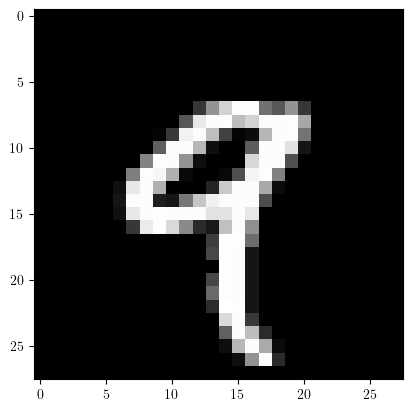

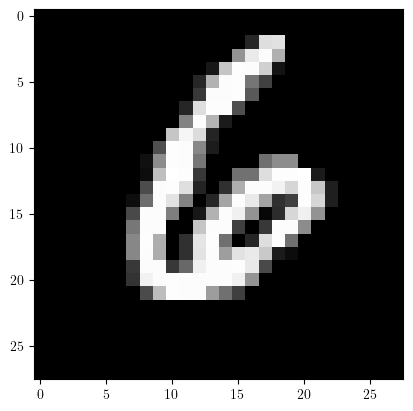

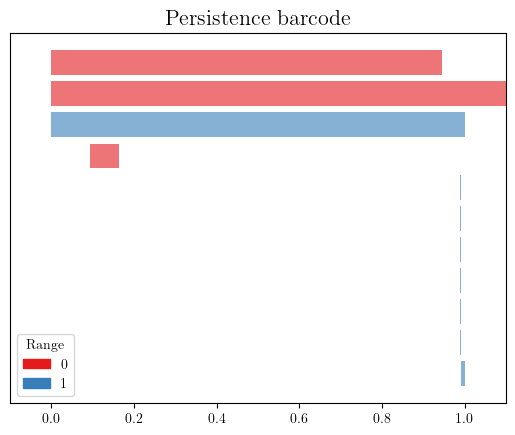

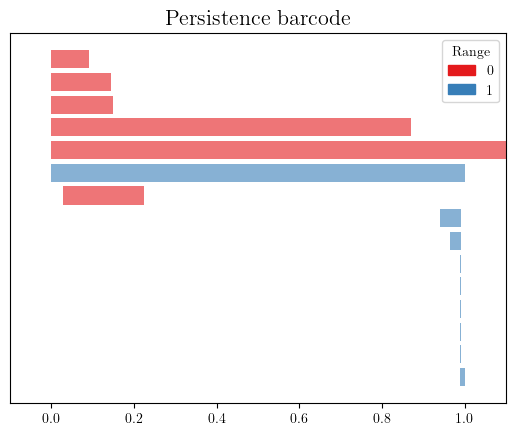

In [28]:
img9 = X_train[4][0][0]
img6 = X_train[13][0][0]
plt.imshow(img9, cmap="gray")
plt.show()
plt.imshow(img6, cmap="gray")
plt.show()

bcd6 = to_gudhi(cripser.computePH(img6))
bcd9 = to_gudhi(cripser.computePH(img9))

gudhi.plot_persistence_barcode(remove_empty_bcd(bcd9))
plt.show()
gudhi.plot_persistence_barcode(remove_empty_bcd(bcd6))
plt.show()

#### Indépendance des dimensions de l'image
Malgré cette limite, l'homologie persistante possède tout de même l'avantage d'être indépendante de la résolution de l'image, contrairement par exemple au premier réseau de neurones du TP, qui ne prend en entrée que des images de 28×28 pixels.

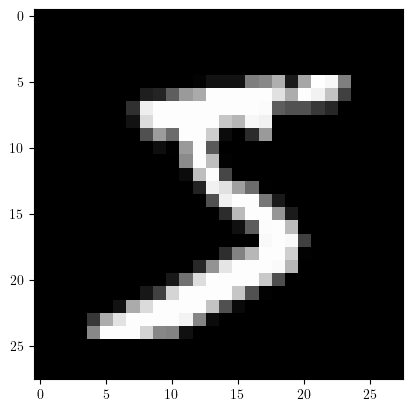

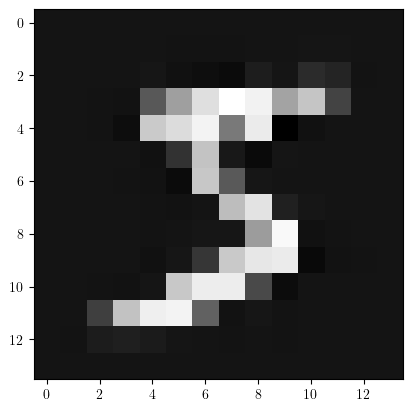

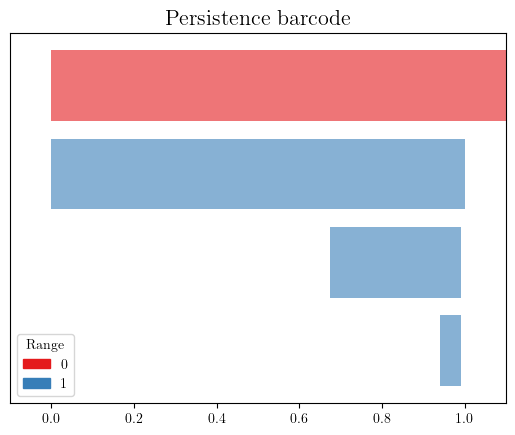

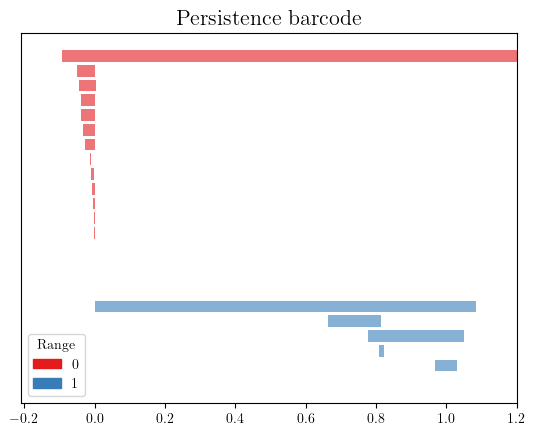

In [29]:
img = X_train[0][0][0].numpy()
img_big = zoom(img, 0.5, order=5)
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(img_big, cmap="gray")
plt.show()

bcd     = to_gudhi(cripser.computePH(img))
bcd_big = to_gudhi(cripser.computePH(img_big))

gudhi.plot_persistence_barcode(remove_empty_bcd(bcd))
plt.show()
gudhi.plot_persistence_barcode(remove_empty_bcd(bcd_big))
plt.show()

## Images radio
Le format standard en imagerie médicale est le format [DICOM](https://fr.wikipedia.org/wiki/Digital_imaging_and_communications_in_medicine) (Digital imaging and communications in medicine). Il permet, entre autres, de stocker une image radio ainsi que de très nombreuses métadonnées (allant de la date du scan jusqu'au constructeur de l'appareil qui a effectué le scan).

Un scan complet (en trois dimensions) se présente souvent sous la forme d'une collection de fichiers DICOM, contenant chacun une image en deux dimensions correspondant à une tranche du scan complet.

In [30]:
f,_ = urllib.request.urlretrieve("http://math.univ-lyon1.fr/~nardingennequin/files/ens/CTSCAN_TCGA-17-Z053.zip")
dsfolder = zipfile.ZipFile(f, "r")
print("Liste des fichiers présents dans l'archive:")
dsfolder.namelist()

Liste des fichiers présents dans l'archive:


['CTSCAN_TCGA-17-Z053/',
 'CTSCAN_TCGA-17-Z053/1-54.dcm',
 'CTSCAN_TCGA-17-Z053/1-41.dcm',
 'CTSCAN_TCGA-17-Z053/1-07.dcm',
 'CTSCAN_TCGA-17-Z053/1-35.dcm',
 'CTSCAN_TCGA-17-Z053/1-24.dcm',
 'CTSCAN_TCGA-17-Z053/1-32.dcm',
 'CTSCAN_TCGA-17-Z053/1-10.dcm',
 'CTSCAN_TCGA-17-Z053/1-53.dcm',
 'CTSCAN_TCGA-17-Z053/1-09.dcm',
 'CTSCAN_TCGA-17-Z053/1-50.dcm',
 'CTSCAN_TCGA-17-Z053/1-39.dcm',
 'CTSCAN_TCGA-17-Z053/1-38.dcm',
 'CTSCAN_TCGA-17-Z053/1-17.dcm',
 'CTSCAN_TCGA-17-Z053/1-42.dcm',
 'CTSCAN_TCGA-17-Z053/1-12.dcm',
 'CTSCAN_TCGA-17-Z053/1-21.dcm',
 'CTSCAN_TCGA-17-Z053/1-27.dcm',
 'CTSCAN_TCGA-17-Z053/1-43.dcm',
 'CTSCAN_TCGA-17-Z053/1-20.dcm',
 'CTSCAN_TCGA-17-Z053/1-01.dcm',
 'CTSCAN_TCGA-17-Z053/1-26.dcm',
 'CTSCAN_TCGA-17-Z053/1-16.dcm',
 'CTSCAN_TCGA-17-Z053/1-08.dcm',
 'CTSCAN_TCGA-17-Z053/1-31.dcm',
 'CTSCAN_TCGA-17-Z053/1-45.dcm',
 'CTSCAN_TCGA-17-Z053/1-48.dcm',
 'CTSCAN_TCGA-17-Z053/1-52.dcm',
 'CTSCAN_TCGA-17-Z053/1-37.dcm',
 'CTSCAN_TCGA-17-Z053/1-23.dcm',
 'CTSCAN_TCGA-17-Z

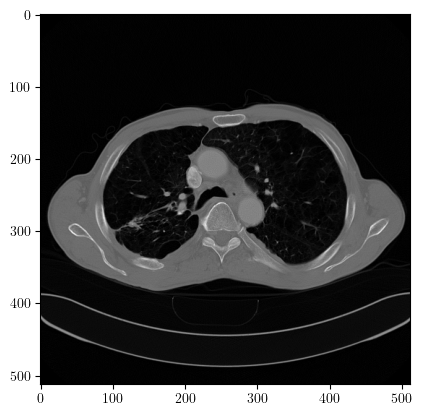

In [31]:
ds = dicom.dcmread(dsfolder.open('CTSCAN_TCGA-17-Z053/1-22.dcm'))
plt.imshow(ds.pixel_array, cmap="gray")
plt.show()

Parmi toutes les métadonnées du fichier, on trouve par exemple l'épaisseur de la tranche et la taille d'un pixel dans l'image (en millimètres).
Ces attributs sont accessibles via des étiquettes spécifiques fixées par le standard.

In [32]:
print("Épaisseur de la tranche:", str(ds[0x0018, 0x0050].value) + "mm")
print("Dimensions d'un pixel:",   str(ds[0x0028, 0x0030].value), "mm × mm")

Épaisseur de la tranche: 5mm
Dimensions d'un pixel: [0.7421875, 0.7421875] mm × mm


**Exercice**: À partir des fichiers DICOM de l'archive `dsfolder`, construisez l'image complète du scan sous la forme d'un tableau numpy en 3 dimensions. Utilisez les deux attributs mentionnés précédemment et la fonction `zoom` pour obtenir une version redimensionnée de l'image telle que chaque pixel corresponde à un cube de côté 1mm.

Extrayez le même cube de 10cm de côté pour chaque image et calculez l'homologie cubique pour les deux cubes.

In [33]:
pass

## Structures de protéines
Les structures 3D de protéines résolues expérimentalement sont répertoriées dans la Protein Data Bank (PDB), et accessibles sous la forme de fichiers `.pdb` ou mmCIF (`.cif`). On travaillera ici sur des fichiers au format PDB. Il s'agit d'un format simple organisé ligne par ligne: chaque ligne est limitée à 80 caractères et contient les informations sur un atome de la structure, ou alors des informations supplémentaires sur la structure contenue dans le fichier (date de résolution publication associée, auteurs, etc).

Une ligne sur un atome contient, par exemple, ses trois coordonnées dans l'espace aux emplacements 31 à 54. En pratique, on utilisera un parser fourni par la bibliothèque [Biopython](https://biopython.org/).

### Chargement d'un fichier PDB

Utilisez la bibliothèque [Biopython](https://biopython.org/docs/dev/Tutorial/chapter_pdb.html) pour charger le fichier PDB [3I40](https://www.rcsb.org/structure/3I40) d'une insuline humaine. Vous pouvez soit télécharger directement le fichier PDB vous-même, soit utiliser la fonctionnalité de téléchargement de la bibliothèque (documentée [ici](https://biopython.org/docs/dev/Tutorial/chapter_pdb.html#downloading-structures-from-the-protein-data-bank)).

In [34]:
parser    = pdb.PDBParser(PERMISSIVE=1)
structure = None

### Extraction d'un nuage de point
L'objet `structure` de Biopython dispose d'une méthode `get_residues` qui retourne un itérateur sur les résidus présents dans la structure.
Les atomes d'un résidu `r` sont accessibles soit avec la méthode `r.get_atoms`, soit directement via leur nom: `r["N"]` pour récupérer l'atome d'azote du backbone, par exemple.

À partir de ces méthodes, récupérez les coordonnées des carbones alpha de chaque résidu dans la structure, dans un tableau de dimension `(N,3)`.

In [35]:
pc = None

### Homologie persistante

Pour calculer l'homologie persistante d'un nuage de points, on utilise `GUDHI`.
Il faut d'abord créer une instance d'une filtration, par exemple `gudhi.DelaunayCechComplex`:

In [ ]:
ac = gudhi.DelaunayCechComplex(points = pc)

La filtration en elle-même est calculée sous la forme d'un objet `SimplexTree`, à partir duquel il est plus aisé pour GUDHI de calculer l'homologie persistante.

In [ ]:
st = ac.create_simplex_tree(output_squared_values=False)
st.compute_persistence()

Les codes-barres sont ensuites accessibles via les fonctions `st.persistence()` (code-barre entier) ou `st.persistence_intervals_in_dimension(dim)` (code-barre sur un seul degré homologique donné).

Calculez et affichez le code-barre de la structure 3D de l'insuline chargée précédemment.

In [38]:
pass

Fin du fichier.